In [1]:
import os
import numpy as np
import pandas as pd
from functools import partial

from heptrkx.nx_graph import utils_plot
from heptrkx.nx_graph import utils_data
from heptrkx.nx_graph import prepare
from heptrkx.nx_graph import get_model


In [2]:
def get_pos_rz(Gp):
    pos = {}
    for node in Gp.nodes():
        r, phi, z = Gp.node[node]['pos'][:3]
        pos[node] = np.array([r, z * -1])
    return pos

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
def plot_networkx_rz(G, ax=None, only_true=False):
    """G is networkx graph,
    node feature: {'pos': [r, phi, z]}
    edge feature: {"solution": []}
    """
    if ax is None:
        fig, ax = plt.subplots()

    n_edges = len(G.edges())
    edge_colors = [0.]*n_edges
    true_edges = []
    for iedge,edge in enumerate(G.edges(data=True)):
        if int(edge[2]['solution'][0]) == 1:
            edge_colors[iedge] = 'r'
            true_edges.append((edge[0], edge[1]))
        else:
            edge_colors[iedge] = 'grey'

    Gp = nx.edge_subgraph(G, true_edges) if only_true else G
    edge_colors = ['k']*len(true_edges) if only_true else edge_colors 

    pos = get_pos_rz(Gp)

    plt.xlabel("r")
    plt.ylabel("z")
    plt.axes([0, 0, 1, 1])
    plt.axis("off")
    nx.draw_networkx(Gp, pos, node_color='#A0CBE2', edge_color=edge_colors,
       width=0.5, with_labels=False, node_size=1, ax=ax, arrows=False)

In [4]:
def get_pos_phir(Gp):
    pos = {}
    for node in Gp.nodes():
        r, phi, z = Gp.node[node]['pos'][:3]
        pos[node] = np.array([phi, r])
    return pos

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
def plot_networkx_phir(G, ax=None, only_true=False):
    """G is networkx graph,
    node feature: {'pos': [r, phi, z]}
    edge feature: {"solution": []}
    """
    if ax is None:
        fig, ax = plt.subplots()

    n_edges = len(G.edges())
    edge_colors = [0.]*n_edges
    true_edges = []
    for iedge,edge in enumerate(G.edges(data=True)):
        if int(edge[2]['solution'][0]) == 1:
            edge_colors[iedge] = 'r'
            true_edges.append((edge[0], edge[1]))
        else:
            edge_colors[iedge] = 'grey'

    Gp = nx.edge_subgraph(G, true_edges) if only_true else G
    edge_colors = ['k']*len(true_edges) if only_true else edge_colors 

    pos = get_pos_phir(Gp)

    plt.xlabel("phi")
    plt.ylabel("r")
    plt.axes([0, 0, 1, 1])
    plt.axis("off")
    nx.draw_networkx(Gp, pos, node_color='#A0CBE2', edge_color=edge_colors,
       width=0.5, with_labels=False, node_size=1, ax=ax, arrows=False)

# Use solution graph

In [6]:
dirname = "./out/nxgraphs_100/"
filename = "event000001000_g000000000"
G_input = prepare.load_data_dicts(dirname + filename + "_INPUT.npz")
G_output = prepare.load_data_dicts(dirname + filename + "_TARGET.npz")

In [7]:
G_solution = utils_data.data_dict_to_nx(G_input, G_output)

/home/aoka/miniconda3/envs/exatrkx/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/aoka/miniconda3/envs/exatrkx/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


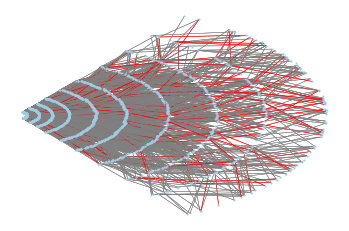

In [8]:
utils_plot.plot_networkx(G_solution, only_true = False)

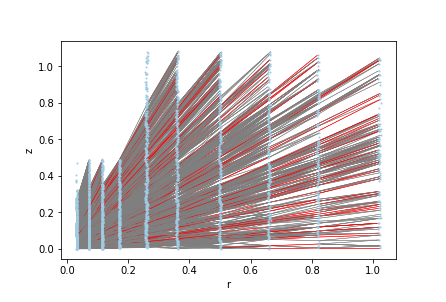

In [9]:
plot_networkx_rz(G_solution)

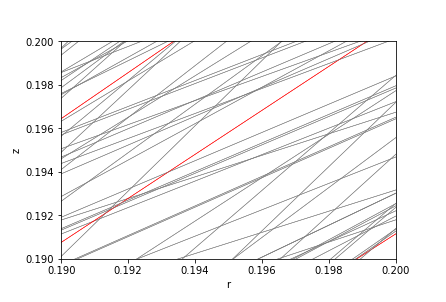

In [10]:
fig, ax = plt.subplots()
ax.set_xlim(0.19, 0.2)
ax.set_ylim(0.19, 0.2)

plot_networkx_rz(G_solution, ax=ax)

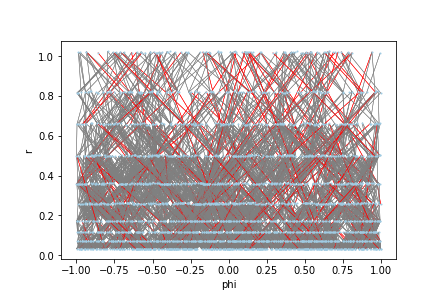

In [11]:
plot_networkx_phir(G_solution)

# Use predicted graph

In [12]:
from __future__ import absolute_import
import tensorflow as tf

from graph_nets import utils_tf
from graph_nets import utils_np

import yaml
import os
import numpy as np

from heptrkx.nx_graph.prepare import inputs_generator
from heptrkx.nx_graph import get_model, utils_data, utils_train, utils_io
from heptrkx.nx_graph.utils_io import ckpt_name
from heptrkx import load_yaml


def create_evaluator(config_name, iteration, input_ckpt=None):
    """
    @config: configuration for train_nx_graph
    """
    # load configuration file
    all_config = load_yaml(config_name)
    config = all_config['segment_training']
    config_tr = config['parameters']

    batch_size = n_graphs   = config_tr['batch_size']   # need optimization
    num_processing_steps_tr = config_tr['n_iters']      ## level of message-passing
    prod_name = config['prod_name']
    if input_ckpt is None:
        input_ckpt = os.path.join(config['output_dir'], prod_name)


    # generate inputs
    generate_input_target = inputs_generator(all_config['make_graph']['out_graph'], n_train_fraction=0.8)

    # build TF graph
    tf.compat.v1.reset_default_graph()
    model = get_model(config['model_name'])

    input_graphs, target_graphs = generate_input_target(n_graphs)
    input_ph  = utils_tf.placeholders_from_data_dicts(input_graphs, force_dynamic_num_graphs=True)
    target_ph = utils_tf.placeholders_from_data_dicts(target_graphs, force_dynamic_num_graphs=True)

    output_ops_tr = model(input_ph, num_processing_steps_tr)
    try:
        sess.close()
    except NameError:
        pass

    sess = tf.Session()
    saver = tf.train.Saver()
    if iteration < 0:
        saver.restore(sess, tf.train.latest_checkpoint(input_ckpt))
    else:
        saver.restore(sess, os.path.join(input_ckpt, ckpt_name.format(iteration)))

    def evaluator(input_graphs, target_graphs, use_digraph=False, bidirection=False):
        """
        input is graph tuples, sizes should match batch_size
        """
        feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
        predictions = sess.run({
            "outputs": output_ops_tr,
            "target": target_ph
        }, feed_dict=feed_dict)
        output = predictions['outputs'][-1]
        return utils_np.graphs_tuple_to_networkxs(output)

    return evaluator

In [13]:
import networkx as nx
import numpy as np

from graph_nets import utils_np, utils_tf

from heptrkx import load_yaml
from heptrkx.nx_graph import utils_plot, utils_data, utils_train, prepare, utils_test
from heptrkx.postprocess import wrangler, analysis, inference
from heptrkx import master

import os
import glob
import argparse
import sys


evtid = 1000
isec = -1
iteration = 17733
input_ckpt = "./bak"


config_file = "./configs/train_edge_classifier_kaggle_share.yaml"
config = load_yaml(config_file)
file_dir = config['make_graph']['out_graph']
hits_graph_dir = config['data']['input_hitsgraph_dir']
trk_dir = config['track_ml']['dir']
if input_ckpt is None:
    input_ckpt = os.path.join(config['segment_training']['output_dir'],
                              config['segment_training']['prod_name'])

base_dir =  os.path.join(file_dir, "event{:09d}_g{:09d}_INPUT.npz")
true_features = ['pt', 'particle_id', 'nhits']
batch_size = config['segment_training']['parameters']['batch_size']


file_names = []
if isec < 0:
    section_patten = base_dir.format(evtid, 0).replace('_g{:09}'.format(0), '*')
    print(section_patten)
    n_sections = int(len(glob.glob(section_patten)))
    print("Total {} sections".format(n_sections))
    file_names = [(base_dir.format(evtid, ii), ii) for ii in range(n_sections)]
else:
    file_names = [(base_dir.format(evtid, isec), isec)]

n_batches = len(file_names)//batch_size if len(file_names)%batch_size==0 else len(file_names)//batch_size + 1
split_inputs = np.array_split(file_names, n_batches)

event = master.Event(trk_dir, evtid)
hits = event.hits
truth = event.truth
model = create_evaluator(config_file, iteration, input_ckpt)

all_graphs = []
is_digraph = True
is_bidirection = False
# evaluate each graph
for ibatch in range(n_batches):
    ## pad batch_size
    current_files = list(split_inputs[ibatch])
    if len(current_files) < batch_size:
        last_file = current_files[-1]
        current_files += [last_file] *(batch_size-len(current_files))


    input_graphs = []
    target_graphs = []
    for items in current_files:
        file_name = items[0]
        with np.load(file_name) as f:
            input_graphs.append(dict(f.items()))

        with np.load(file_name.replace("INPUT", "TARGET")) as f:
            target_graphs.append(dict(f.items()))

    graphs = model(utils_np.data_dicts_to_graphs_tuple(input_graphs),
                   utils_np.data_dicts_to_graphs_tuple(target_graphs),
                   use_digraph=is_digraph, bidirection=is_bidirection
                  )

    # decorate the graph with truth info
    #for ii in range(batch_size):
    #    idx = int(current_files[ii][1])
    #    id_name = os.path.join(hits_graph_dir, "event{:09d}_g{:03d}_ID.npz".format(evtid, idx))
    #    with np.load(id_name) as f:
    #        hit_ids = f['ID']

    #    for node in graphs[ii].nodes():
    #        hit_id = hit_ids[node]
    #        graphs[ii].node[node]['hit_id'] = hit_id
    #        graphs[ii].node[node]['info'] = hits[hits['hit_id'] == hit_id][true_features].values

    #    graphs[ii].graph['info'] = [idx] ## section ID

    #all_graphs += graphs

#weights = []
#truths = []
#for G in all_graphs:
#    weights += [G.edges[edge]['predict'][0] for edge in G.edges()]
#    truths += [G.edges[edge]['solution'][0] for edge in G.edges()]

./out/nxgraphs_100/event000001000*_INPUT.npz
Total 16 sections
Total Events: 100 with 16 sections, total 1600 files 
Training data: [0, 79] events, total 1280 files
Testing data:  [80, 100] events, total 320 files
Training and testing graphs are selected sequantially from their corresponding pools

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from ./bak/checkpoint_17733.ckpt


In [29]:
G_predict = graphs[0]
for edge in G_solution.edges:
    print(edge[0]['solution'])

TypeError: 'int' object is not subscriptable

KeyError: 'solution'

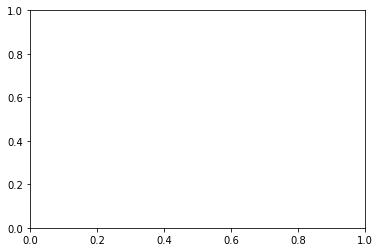

In [15]:
utils_plot.plot_networkx(G_predict, only_true = False)
utils_plot.plot_networkx(G_solution, only_true = False)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0.19, 0.2)
ax.set_ylim(0.19, 0.2)

plot_networkx_rz(G_predict, ax=ax)

fig, ax = plt.subplots()
ax.set_xlim(0.19, 0.2)
ax.set_ylim(0.19, 0.2)

plot_networkx_rz(G_solution, ax=ax)